<a href="https://colab.research.google.com/github/SpandanaDC/Medicinal-plant-detection/blob/main/Copy_of_medicinal_plant_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Step 1: Setup and Unzip
import os
import zipfile
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define Paths
zip_path = '/content/drive/MyDrive/Medicinal Leaf Dataset.zip'
extraction_path = '/content/dataset'

# Unzip
if os.path.exists(zip_path):
    print("Unzipping dataset... this may take a few moments.")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extraction_path)
    print(f" Dataset extracted to: {extraction_path}")
else:
    print(f" File not found: {zip_path}")

Mounted at /content/drive
Unzipping dataset... this may take a few moments.
 Dataset extracted to: /content/dataset


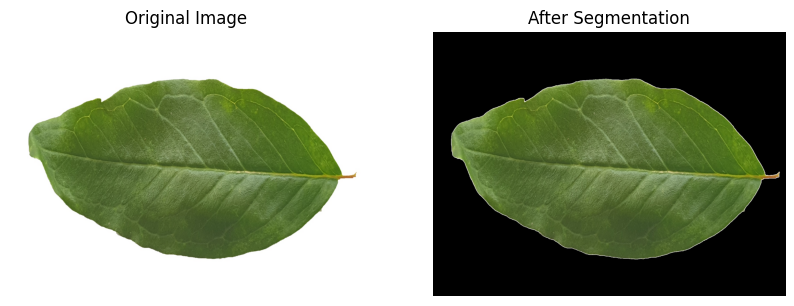

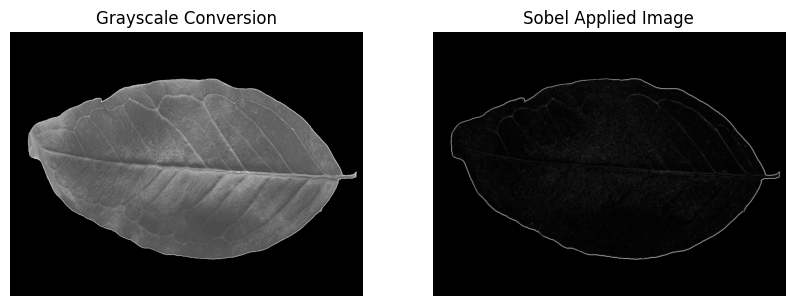

In [ ]:
# Step 2: Visualization of Image Processing Steps
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from skimage import color

# Define the segmentation function exactly as in the project
def hsv_mask(image):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_saturation_threshold = 60
    saturation_mask = cv2.inRange(hsv_image[:, :, 1], lower_saturation_threshold, 255)

    kernel_size = (5, 5)
    smoothed_mask = cv2.GaussianBlur(saturation_mask, kernel_size, 0)

    _, leaf_mask = cv2.threshold(smoothed_mask, 1, 255, cv2.THRESH_BINARY)

    kernel = np.ones((5, 5), np.uint8)
    closed_mask = cv2.morphologyEx(leaf_mask, cv2.MORPH_CLOSE, kernel)

    segmented_image = image.copy()
    segmented_image[closed_mask == 0] = [0, 0, 0]
    return segmented_image

# --- Select a Random Image ---
dataset_path = "/content/dataset/Medicinal Leaf Dataset/Segmented Medicinal Leaf Images/"
if os.path.exists(dataset_path):
    rand_class = random.choice(os.listdir(dataset_path))
    rand_file = random.choice(os.listdir(os.path.join(dataset_path, rand_class)))
    img_path = os.path.join(dataset_path, rand_class, rand_file)

    # Read Image
    image = cv2.imread(img_path)

    # 1. Apply Segmentation
    hsv_seg_image = hsv_mask(image)

    # 2. Convert to Grayscale
    # Note: In the project, they often convert the segmented image to gray
    gray_image = color.rgb2gray(cv2.cvtColor(hsv_seg_image, cv2.COLOR_BGR2RGB))

    # 3. Apply Sobel Filter
    gradient_x = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize=3)
    gradient_y = cv2.Sobel(gray_image, cv2.CV_64F, 0, 1, ksize=3)
    gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
    sobel_image = cv2.normalize(gradient_magnitude, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    # --- VISUALIZE (Like the Document) ---

    # Plot 1: Original vs Segmented
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(cv2.cvtColor(hsv_seg_image, cv2.COLOR_BGR2RGB))
    axes[1].set_title('After Segmentation')
    axes[1].axis('off')
    plt.show()

    # Plot 2: Grayscale vs Sobel
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(gray_image, cmap='gray')
    axes[0].set_title('Grayscale Conversion')
    axes[0].axis('off')

    axes[1].imshow(sobel_image, cmap='gray')
    axes[1].set_title('Sobel Applied Image')
    axes[1].axis('off')
    plt.show()

else:
    print("Dataset path not found.")

In [ ]:
# Step 3: Mass Feature Extraction
import csv
from skimage import feature
from skimage.filters import gabor
from tqdm.notebook import tqdm

# --- Feature Functions ---
def calculate_color_moments(image):
    channels = cv2.split(image)
    color_moments = []
    for channel in channels:
        mean = np.mean(channel)
        variance = np.var(channel)
        skewness = np.mean((channel - mean) ** 3) / (variance ** (3/2) + 1e-6)
        color_moments.extend([mean, variance, skewness])
    return color_moments

def extract_lbp_glcm_features(image):
    # LBP
    lbp = feature.local_binary_pattern(image, P=8, R=1, method='uniform')
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 10), range=(0, 10))
    lbp_hist = lbp_hist.astype(float)
    lbp_hist /= (lbp_hist.sum() + 1e-6)

    # GLCM
    # Ensure image is integer type for GLCM
    img_uint = (image * 255).astype(np.uint8) if image.dtype != np.uint8 else image
    if len(img_uint.shape) > 2: img_uint = cv2.cvtColor(img_uint, cv2.COLOR_BGR2GRAY)

    glcm = feature.graycomatrix(img_uint, [1], [0], symmetric=True, normed=True)
    glcm_props = []
    for prop in ['dissimilarity', 'contrast', 'homogeneity', 'energy', 'correlation']:
        glcm_props.append(feature.graycoprops(glcm, prop)[0, 0])

    # Gabor
    gabor_features = []
    theta = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    frequency = [0.1, 0.5, 1.0]
    for t in theta:
        for f in frequency:
            filt_real, _ = gabor(image, frequency=f, theta=t)
            gabor_features.append(np.mean(filt_real))

    return lbp_hist, np.array(glcm_props), np.array(gabor_features)

# --- Main Loop ---
csv_file = "/content/drive/MyDrive/ExtractedFeatures.csv"
dataset_path = "/content/dataset/Medicinal Leaf Dataset/Segmented Medicinal Leaf Images/"

# Define CSV Header dynamically
header = []
header.extend([f"LBP_{i}" for i in range(9)])
header.extend([f"GLCM_{p}" for p in ['Dissimilarity', 'Contrast', 'Homogeneity', 'Energy', 'Correlation']])
header.extend([f"Gabor_{i}" for i in range(12)])
header.extend([f"Sobel_LBP_{i}" for i in range(9)])
header.extend([f"Sobel_GLCM_{p}" for p in ['Dissimilarity', 'Contrast', 'Homogeneity', 'Energy', 'Correlation']])
header.extend([f"Sobel_Gabor_{i}" for i in range(12)])
header.extend([f"Color_{c}_{m}" for c in ['R','G','B'] for m in ['Mean','Var','Skew']])
header.append("Label")

print("Extracting Features...")
processed_class_counts = {}
with open(csv_file, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(header)

    if os.path.exists(dataset_path):
        classes = os.listdir(dataset_path)
        print(f"Found {len(classes)} classes in the dataset path.")
        for cls in tqdm(classes):
            cls_path = os.path.join(dataset_path, cls)
            if not os.path.isdir(cls_path):
                print(f"Skipping {cls} as it is not a directory.")
                continue

            processed_count_for_class = 0
            for img_name in os.listdir(cls_path):
                try:
                    img_full_path = os.path.join(cls_path, img_name)
                    image = cv2.imread(img_full_path)
                    if image is None:
                        # print(f"Skipping unreadable image: {img_full_path}")
                        continue

                    # Resize for consistency
                    image = cv2.resize(image, (256, 256))

                    # 1. Color Features
                    hsv = hsv_mask(image)
                    rgb = cv2.cvtColor(hsv, cv2.COLOR_BGR2RGB)
                    moments = calculate_color_moments(rgb)

                    # 2. Texture (Standard)
                    gray = color.rgb2gray(rgb)
                    lbp, glcm, gab = extract_lbp_glcm_features(gray)

                    # 3. Texture (Sobel)
                    dx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
                    dy = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
                    mag = np.sqrt(dx**2 + dy**2)
                    mag = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
                    s_lbp, s_glcm, s_gab = extract_lbp_glcm_features(mag)

                    # Combine
                    row = np.concatenate([lbp, glcm, gab, s_lbp, s_glcm, s_gab, moments, [cls]])
                    writer.writerow(row)
                    processed_count_for_class += 1

                except Exception as e:
                    print(f"Error processing {img_full_path}: {e}")
            processed_class_counts[cls] = processed_count_for_class
            print(f"Processed {processed_count_for_class} images for class: {cls}")

print("\n--- Feature Extraction Summary ---")
for cls, count in processed_class_counts.items():
    print(f"Class '{cls}': {count} images processed.")
if len(processed_class_counts) < 2:
    print("WARNING: Only one class was processed. Please ensure your dataset has multiple classes.")
print("Feature Extraction Complete.")


Extracting Features...
Found 30 classes in the dataset path.


  0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Processed 43 images for class: Hibiscus Rosa-sinensis
Processed 65 images for class: Psidium Guajava (Guava)
Processed 97 images for class: Mentha (Mint)
Processed 56 images for class: Syzygium Jambos (Rose Apple)
Processed 56 images for class: Artocarpus Heterophyllus (Jackfruit)
Processed 56 images for class: Muntingia Calabura (Jamaica Cherry-Gasagase)
Processed 62 images for class: Nerium Oleander (Oleander)
Processed 60 images for class: Azadirachta Indica (Neem)
Processed 50 images for class: Alpinia Galanga (Rasna)
Processed 60 images for class: Murraya Koenigii (Curry)
Processed 40 images for class: Nyctanthes Arbor-tristis (Parijata)
Processed 57 images for class: Citrus Limon (Lemon)
Processed 34 images for class: Brassica Juncea (Indian Mustard)
Processed 71 images for class: Jasminum (Jasmine)
Processed 79 images for class: Punica Granatum (Pomegranate)
Processed 48 images for class: Plectranthus Amboinicus (Mexican Mint)
Processed 39 images for class: Syzygium Cumini (Jamu

--- DIAGNOSTICS ---
Rows in CSV: 1835
Unique Classes Found: 30
Classes: ['Hibiscus Rosa-sinensis' 'Psidium Guajava (Guava)' 'Mentha (Mint)'
 'Syzygium Jambos (Rose Apple)' 'Artocarpus Heterophyllus (Jackfruit)'
 'Muntingia Calabura (Jamaica Cherry-Gasagase)'
 'Nerium Oleander (Oleander)' 'Azadirachta Indica (Neem)'
 'Alpinia Galanga (Rasna)' 'Murraya Koenigii (Curry)'
 'Nyctanthes Arbor-tristis (Parijata)' 'Citrus Limon (Lemon)'
 'Brassica Juncea (Indian Mustard)' 'Jasminum (Jasmine)'
 'Punica Granatum (Pomegranate)' 'Plectranthus Amboinicus (Mexican Mint)'
 'Syzygium Cumini (Jamun)' 'Pongamia Pinnata (Indian Beech)'
 'Mangifera Indica (Mango)' 'Basella Alba (Basale)'
 'Amaranthus Viridis (Arive-Dantu)' 'Carissa Carandas (Karanda)'
 'Piper Betle (Betel)' 'Ocimum Tenuiflorum (Tulsi)'
 'Ficus Religiosa (Peepal Tree)' 'Santalum Album (Sandalwood)'
 'Moringa Oleifera (Drumstick)'
 'Tabernaemontana Divaricata (Crape Jasmine)'
 'Trigonella Foenum-graecum (Fenugreek)' 'Ficus Auriculata (Roxbu

/usr/local/lib/python3.12/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 2 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 3 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

QDA: 0.24796

 Best Model: Support Vector Machine with Accuracy: 0.96185


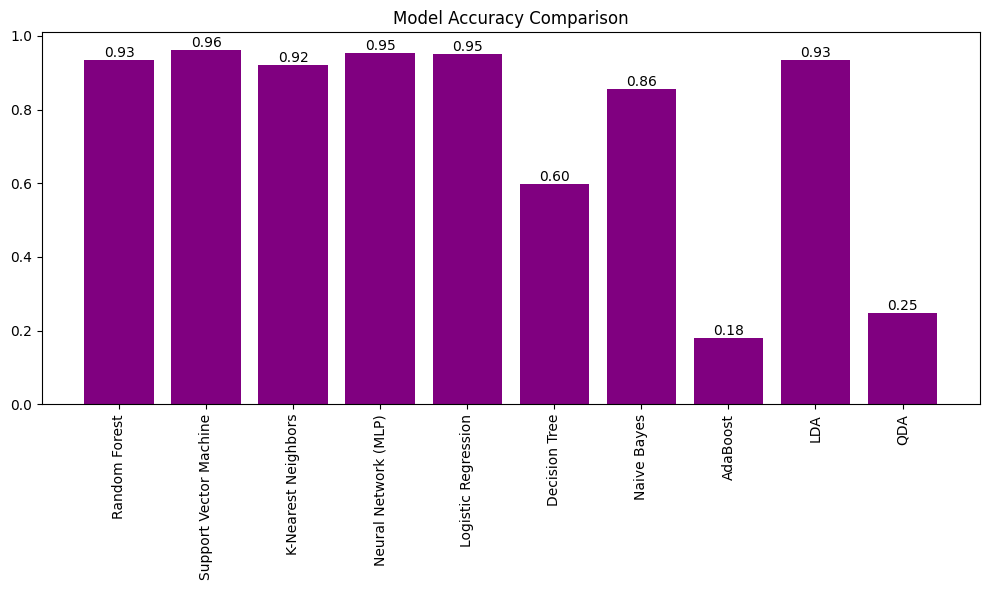

 Models saved successfully.


In [ ]:
import pandas as pd
import os
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
import matplotlib.pyplot as plt

# --- 1. DIAGNOSTIC CHECK ---
csv_path = "/content/drive/MyDrive/ExtractedFeatures.csv"
dataset_path = "/content/dataset/Medicinal Leaf Dataset/Segmented Medicinal Leaf Images/"

print("--- DIAGNOSTICS ---")

# Check CSV Data
if os.path.exists(csv_path):
    df = pd.read_csv(csv_path)
    df = df.dropna()
    unique_labels = df['Label'].unique()
    print(f"Rows in CSV: {len(df)}")
    print(f"Unique Classes Found: {len(unique_labels)}")
    print(f"Classes: {unique_labels}")

    if len(unique_labels) < 2:
        print("\n CRITICAL ERROR: Only 1 class found. Training requires at least 2.")
        print("Possible causes:")
        print("1. The zip file only contained one folder.")
        print("2. The 'dataset_path' in Step 2 was incorrect.")

        # Attempt to find the correct path automatically
        print("\nSearching for correct image folders...")
        found_correct_path = False
        for root, dirs, files in os.walk("/content/dataset"):
            if len(dirs) > 2: # If we find a folder with multiple subfolders
                # Check if they look like class folders (contain images)
                sample_dir = os.path.join(root, dirs[0])
                if len(os.listdir(sample_dir)) > 0:
                    print(f" Found potential data source at: {root}")
                    print(f"   It has {len(dirs)} folders (classes).")
                    print(f"   Please RE-RUN STEP 2 using this path in the 'dataset_path' variable.")
                    found_correct_path = True
                    break

        if not found_correct_path:
            print(" Could not auto-detect multiple classes. Please check your zip file structure.")
else:
    print(" CSV file not found. Please rerun Step 2.")

# --- 2. TRAINING (Only runs if data is valid) ---
if 'df' in locals() and len(df['Label'].unique()) > 1:
    print("\n--- STARTING TRAINING ---")

    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]

    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # PCA & Scaling
    print("Applying PCA (n=53) and Scaling...")
    pca = PCA(n_components=53)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_pca)
    X_test_scaled = scaler.transform(X_test_pca)

    # Classifiers
    classifiers = {
        'Random Forest': RandomForestClassifier(random_state=42),
        'Support Vector Machine': SVC(kernel='linear', C=10, gamma=0.1),
        'K-Nearest Neighbors': KNeighborsClassifier(),
        'Neural Network (MLP)': MLPClassifier(hidden_layer_sizes=(50, 50), max_iter=1000, random_state=42),
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
        'Decision Tree': DecisionTreeClassifier(random_state=42),
        'Naive Bayes': GaussianNB(),
        'AdaBoost': AdaBoostClassifier(random_state=42),
        'LDA': LinearDiscriminantAnalysis(),
        'QDA': QuadraticDiscriminantAnalysis()
    }

    accuracy_results = {}
    best_acc = 0
    best_model_name = ""
    best_model = None

    print(f"Training on {len(X_train)} samples...")

    for name, clf in classifiers.items():
        try:
            clf.fit(X_train_scaled, y_train)
            preds = clf.predict(X_test_scaled)
            acc = accuracy_score(y_test, preds)
            accuracy_results[name] = acc
            print(f"{name}: {acc:.5f}")

            if acc > best_acc:
                best_acc = acc
                best_model_name = name
                best_model = clf
        except Exception as e:
            print(f"{name} Failed: {e}")

    print(f"\n Best Model: {best_model_name} with Accuracy: {best_acc:.5f}")

    # Visualization
    names = list(accuracy_results.keys())
    values = list(accuracy_results.values())
    plt.figure(figsize=(10, 6))
    bars = plt.bar(names, values, color='purple')
    for bar, value in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width() / 2, value, '{:.2f}'.format(value), ha='center', va='bottom')
    plt.xticks(rotation=90)
    plt.title("Model Accuracy Comparison")
    plt.tight_layout()
    plt.show()

    # Save
    save_dir = "/content/drive/MyDrive/ML_Models_Exact/"
    if not os.path.exists(save_dir): os.makedirs(save_dir)

    with open(os.path.join(save_dir, 'Best_Model.pkl'), 'wb') as f:
        pickle.dump(best_model, f)
    with open(os.path.join(save_dir, 'pca.pkl'), 'wb') as f:
        pickle.dump(pca, f)
    with open(os.path.join(save_dir, 'scaler.pkl'), 'wb') as f:
        pickle.dump(scaler, f)
    print(" Models saved successfully.")

🔍 Searching for trained model...
 Found model at: /content/drive/MyDrive/ML_Models_Exact/Best_Model.pkl
 Processing: Hibiscus Rosa-sinensis / HR-S-033.jpg


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


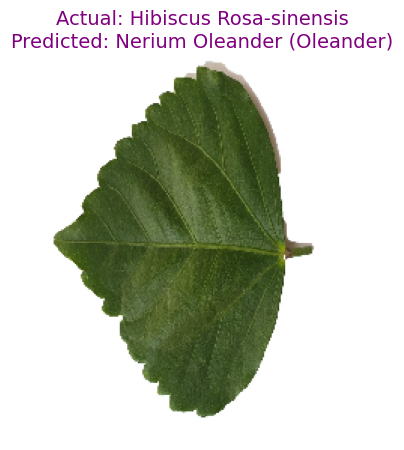

 Final Prediction: Nerium Oleander (Oleander)


In [ ]:
# Step 5: Robust Prediction (Auto-detects Model Path)
import os
import cv2
import pickle
import numpy as np
import random
import matplotlib.pyplot as plt
from skimage import feature, color
from skimage.filters import gabor

# --- 1. Define Functions (Required for Feature Extraction) ---
def hsv_mask(image):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower = 60
    # Note: upper bound 255 is implied in standard opencv ranges if not specified,
    # but your original code used a specific mask logic. We stick to that.
    saturation_mask = cv2.inRange(hsv_image[:, :, 1], lower, 255)
    kernel = np.ones((5, 5), np.uint8)
    smoothed = cv2.GaussianBlur(saturation_mask, (5,5), 0)
    _, leaf_mask = cv2.threshold(smoothed, 1, 255, cv2.THRESH_BINARY)
    closed = cv2.morphologyEx(leaf_mask, cv2.MORPH_CLOSE, kernel)
    segmented = image.copy()
    segmented[closed == 0] = [0, 0, 0]
    return segmented

def calculate_color_moments(image):
    channels = cv2.split(image)
    moments = []
    for channel in channels:
        mean = np.mean(channel)
        var = np.var(channel)
        skew = np.mean((channel - mean) ** 3) / (var ** 1.5 + 1e-6)
        moments.extend([mean, var, skew])
    return moments

def extract_lbp_glcm_features(image):
    lbp = feature.local_binary_pattern(image, P=8, R=1, method='uniform')
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 10), range=(0, 10))
    lbp_hist = lbp_hist.astype(float)
    lbp_hist /= (lbp_hist.sum() + 1e-6)

    # Ensure image is uint8
    if image.dtype != np.uint8: image = (image * 255).astype(np.uint8)

    glcm = feature.graycomatrix(image, [1], [0], symmetric=True, normed=True)
    glcm_props = []
    for prop in ['dissimilarity', 'contrast', 'homogeneity', 'energy', 'correlation']:
        glcm_props.append(feature.graycoprops(glcm, prop)[0, 0])

    gabor_feats = []
    for t in [0, np.pi/4, np.pi/2, 3*np.pi/4]:
        for f in [0.1, 0.5, 1.0]:
            filt_real, _ = gabor(image, frequency=f, theta=t)
            gabor_feats.append(np.mean(filt_real))

    return lbp_hist, np.array(glcm_props), np.array(gabor_feats)

# --- 2. Locate and Load Model ---
# Possible locations where the previous steps might have saved the model
possible_paths = [
    '/content/drive/MyDrive/ML_Models_Exact/Best_Model.pkl',  # Path from the "Fix" step
    '/content/drive/MyDrive/Best_Model_Project.pkl',          # Path from the "Visual" step
    '/content/drive/MyDrive/ML_Models/Best_Model.pkl'         # Path from the first step
]

model, pca, scaler = None, None, None
base_dir = ""

print("🔍 Searching for trained model...")
for path in possible_paths:
    if os.path.exists(path):
        print(f" Found model at: {path}")
        base_dir = os.path.dirname(path)

        # Determine filenames based on the folder we found
        if "Project" in path:
            pca_name = 'pca_project.pkl'
            scaler_name = 'scaler_project.pkl'
        else:
            pca_name = 'pca.pkl'
            scaler_name = 'scaler.pkl'

        try:
            with open(path, 'rb') as f: model = pickle.load(f)
            with open(os.path.join(base_dir, pca_name), 'rb') as f: pca = pickle.load(f)
            with open(os.path.join(base_dir, scaler_name), 'rb') as f: scaler = pickle.load(f)
            break # Stop searching if successful
        except Exception as e:
            print(f" Error loading from {path}: {e}")

if model is None:
    raise FileNotFoundError(" Could not find any trained model files! Please re-run Step 4.")

# --- 3. Process Random Image & Predict ---
dataset_path = "/content/dataset/Medicinal Leaf Dataset/Segmented Medicinal Leaf Images/"

if os.path.exists(dataset_path):
    # Pick Random Image
    rand_class = random.choice(os.listdir(dataset_path))
    class_path = os.path.join(dataset_path, rand_class)
    if os.path.isdir(class_path):
        rand_file = random.choice(os.listdir(class_path))
        img_path = os.path.join(class_path, rand_file)

        print(f" Processing: {rand_class} / {rand_file}")

        # Load & Resize
        image = cv2.imread(img_path)
        image = cv2.resize(image, (256, 256))

        # Extract Features (Exact Pipeline)
        hsv = hsv_mask(image)
        rgb = cv2.cvtColor(hsv, cv2.COLOR_BGR2RGB)
        moments = calculate_color_moments(rgb)

        gray = color.rgb2gray(rgb)
        gray_u = (gray * 255).astype(np.uint8)
        lbp, glcm, gab = extract_lbp_glcm_features(gray_u)

        dx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
        dy = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
        mag = np.sqrt(dx**2 + dy**2)
        mag_u = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        s_lbp, s_glcm, s_gab = extract_lbp_glcm_features(mag_u)

        # Vectorize
        features = np.concatenate([lbp, glcm, gab, s_lbp, s_glcm, s_gab, moments]).reshape(1, -1)

        # Predict
        X_pca = pca.transform(features)
        X_sc = scaler.transform(X_pca)
        prediction = model.predict(X_sc)

        # --- 4. Show Result ---
        plt.figure(figsize=(5, 5))
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(f"Actual: {rand_class}\nPredicted: {prediction[0]}", fontsize=14, color='purple')
        plt.axis('off')
        plt.show()

        print(f" Final Prediction: {prediction[0]}")
    else:
        print("Error: Selected class is not a directory.")
else:
    print("Error: Dataset path not found.")